In [1]:
import pandas as pd  
import numpy as np
import math
import matplotlib.pyplot as plt  
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import preprocessing
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#import xgboost as xgb
from sklearn.metrics import roc_curve, auc
#import scikitplot as skplt #conda install -c conda-forge scikit-plot
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_absolute_error, accuracy_score

In [3]:
dataset = pd.read_csv('fraud_oracle.csv')

dataset.head()


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


# Preparing the dataset

In [4]:
#removing zeros
print('DayOfWeekClaimed has ', len(dataset.loc[(dataset['DayOfWeekClaimed']=='0')]), ' row(s) with a 0')
print('MonthClaimed has ',len(dataset.loc[(dataset['MonthClaimed']=='0')]),' row(s) with a 0') 
print(' ')

DayOfWeekClaimed has  1  row(s) with a 0
MonthClaimed has  1  row(s) with a 0
 


In [5]:
print(dataset.loc[(dataset['DayOfWeekClaimed']=='0')])
print(dataset.loc[(dataset['MonthClaimed']=='0')])

     Month  WeekOfMonth DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
1516   Jul            2    Monday  Honda        Rural                0   

     MonthClaimed  WeekOfMonthClaimed   Sex MaritalStatus  ...  AgeOfVehicle  \
1516            0                   1  Male        Single  ...           new   

     AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
1516          16 to 17                No             No  External   

      NumberOfSuppliments  AddressChange_Claim  NumberOfCars  Year  BasePolicy  
1516                 none            no change     1 vehicle  1994  All Perils  

[1 rows x 33 columns]
     Month  WeekOfMonth DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
1516   Jul            2    Monday  Honda        Rural                0   

     MonthClaimed  WeekOfMonthClaimed   Sex MaritalStatus  ...  AgeOfVehicle  \
1516            0                   1  Male        Single  ...           new   

     AgeOfPolicyHolder PoliceReportFiled WitnessPresent 

In [6]:
df = dataset.loc[dataset['DayOfWeekClaimed']!='0']

In [7]:
dataset.shape

(15420, 33)

In [8]:
df.reset_index(drop=True, inplace=True)
len(df)

15419

In [9]:
#Checking which Policy Holder has Age=0
print(len(df[df['Age']==0]))

df.loc[df['Age']==0, 'AgeOfPolicyHolder']
df_age0_idx = (df['Age']==0)

319


In [10]:
#Policy Holder that is aged between 16 and 17 years
df.loc[(df['Age']==0),'AgeOfPolicyHolder'].unique()

array(['16 to 17'], dtype=object)

In [11]:
#we split the variable 'AgeOfPolicyHolder' so we can check that the age variable is in range for policyholder

groupings = []
for holder in df['AgeOfPolicyHolder']:
    if 'to' in holder :
        temp = holder.split()
        nr=[int(temp[0]),int(temp[2])]
        groupings.append(nr)
    else :
        temp = holder.split()
        nr = [int(temp[1]),129]
        groupings.append(nr)

In [12]:
age_idx = []
rw_idx = []
for r in range(len(df['Age'])):
    if (df.loc[r,'Age']>= groupings[r][0]) & (df.loc[r,'Age']<= groupings[r][1]):
        age_idx.append(0)
    else:
        age_idx.append(1)
        rw_idx.append(r)

In [13]:
print(len(df.loc[list(rw_idx),('Age','AgeOfPolicyHolder')]))
df.loc[list(rw_idx),('Age','AgeOfPolicyHolder')].head()

7241


,Age,AgeOfPolicyHolder
0,21,26 to 30
4,27,31 to 35
5,20,21 to 25
7,0,16 to 17
8,30,31 to 35


In [14]:
#We put an age of 16.5 to all rows with missing Age value
df.loc[list(df_age0_idx),'Age']=16.5

In [15]:
print(df['Age'].unique()==0)
len(df[df['Age']==0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


0

In [16]:
#Checking to see if we have duplicate rows
print(len(df.drop_duplicates())==len(df))

True


In [17]:
#changing the name
dataset=df

Converting to binary values:

In [18]:
# Convert to binary values
dataset["AccidentArea"] = dataset["AccidentArea"].map({"Urban":1, "Rural":0})
dataset["AccidentArea"] = dataset["AccidentArea"].astype(int)

In [19]:

dataset["AgentType"] = dataset["AgentType"].map({"External":1, "Internal":0})
dataset["AgentType"] = dataset["AgentType"].astype(int)

In [20]:

dataset["WitnessPresent"] = dataset["WitnessPresent"].map({"No":0, "Yes":1})
dataset["WitnessPresent"] = dataset["WitnessPresent"].astype(int)

In [21]:

dataset["PoliceReportFiled"] = dataset["PoliceReportFiled"].map({"No":0, "Yes":1})
dataset["PoliceReportFiled"] = dataset["PoliceReportFiled"].astype(int)

In [22]:

dataset["Sex"] = dataset["Sex"].map({"Male":0, "Female":1})
dataset["Sex"] = dataset["Sex"].astype(int)

In [23]:

dataset["Fault"] = dataset["Fault"].map({"Policy Holder":1, "Third Party":0})
dataset["Fault"] = dataset["Fault"].astype(int)

In [24]:
pd.set_option('display.max_columns', None)

In [25]:
    dataset.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,1,Tuesday,Jan,1,1,Single,21.0,1,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,0,0,1,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,1,Monday,Jan,4,0,Single,34.0,1,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,1,0,1,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,1,Thursday,Nov,2,0,Married,47.0,1,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,0,0,1,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,0,Friday,Jul,1,0,Married,65.0,0,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,1,0,1,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,1,Tuesday,Feb,2,1,Single,27.0,0,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,0,0,1,none,no change,1 vehicle,1994,Collision


Dropping the variables that are not significant for the model

In [26]:
dataset.drop(["PolicyNumber", "RepNumber"],inplace=True,axis=1)

In [27]:
dataset.drop(["DayOfWeekClaimed"],inplace=True,axis=1)

In [28]:
dataset.drop(["PolicyType"],inplace=True,axis=1)

In [29]:
dataset.drop(["AgeOfPolicyHolder"],inplace=True,axis=1)

In [30]:
dataset.drop(["NumberOfSuppliments", "AddressChange_Claim"],inplace=True,axis=1)

In [31]:
dataset.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,VehicleCategory,VehiclePrice,FraudFound_P,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,1,Jan,1,1,Single,21.0,1,Sport,more than 69000,0,300,1,more than 30,more than 30,none,3 years,0,0,1,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,1,Jan,4,0,Single,34.0,1,Sport,more than 69000,0,400,4,more than 30,more than 30,none,6 years,1,0,1,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,1,Nov,2,0,Married,47.0,1,Sport,more than 69000,0,400,3,more than 30,more than 30,1,7 years,0,0,1,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,0,Jul,1,0,Married,65.0,0,Sport,20000 to 29000,0,400,2,more than 30,more than 30,1,more than 7,1,0,1,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,1,Feb,2,1,Single,27.0,0,Sport,more than 69000,0,400,1,more than 30,more than 30,none,5 years,0,0,1,1 vehicle,1994,Collision


Creating dummy variables to categorical variables that are objects

In [32]:

dataset = pd.get_dummies(dataset, columns = ["Make"], drop_first = True, dtype=int)


In [33]:

dataset = pd.get_dummies(dataset, columns = ["Days_Policy_Accident"], drop_first = True, dtype=int)


In [34]:

dataset = pd.get_dummies(dataset, columns = ["Month"], drop_first = True, dtype=int)


In [35]:

dataset = pd.get_dummies(dataset, columns = ["Days_Policy_Claim"], drop_first = True, dtype=int)


In [36]:

dataset = pd.get_dummies(dataset, columns = ["VehiclePrice"], drop_first = True, dtype=int)


In [37]:

dataset = pd.get_dummies(dataset, columns = ["AgeOfVehicle"], drop_first = True, dtype=int)


In [38]:

dataset = pd.get_dummies(dataset, columns = ["PastNumberOfClaims"], drop_first = True, dtype=int)


In [39]:

dataset = pd.get_dummies(dataset, columns = ["Year"], drop_first = True, dtype=int)


In [40]:

dataset = pd.get_dummies(dataset, columns = ["DayOfWeek"], drop_first = True, dtype=int)


In [41]:

dataset = pd.get_dummies(dataset, columns = ["VehicleCategory"], drop_first = True, dtype=int)


In [42]:

dataset = pd.get_dummies(dataset, columns = ["MonthClaimed"], drop_first = True, dtype=int)


In [43]:

dataset = pd.get_dummies(dataset, columns = ["NumberOfCars"], drop_first = True, dtype=int)


In [44]:

dataset = pd.get_dummies(dataset, columns = ["BasePolicy"], drop_first = True, dtype=int)


In [45]:

dataset = pd.get_dummies(dataset, columns = ["MaritalStatus"], drop_first = True, dtype=int)


In [46]:
dataset.shape

(15419, 92)

Dividing the dataset for target and income variables

In [47]:
X = dataset.drop(columns=['FraudFound_P'])
y = dataset['FraudFound_P'].to_frame()

Splitting into train and test set

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)


# DECISION TREE 

Tries to find a way to create rules for splitting data, searching for the best threshold for splitting. It goes through each variable to find the optimal threshold and it is keen on 'purity' (for example: 0 on side, 1 on the other). For decision trees, it is more important to evaluate the purity of the branch to RMSE, than accuracy and precision.

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
max_depth = range(1,30)
#max_feature = list(range(1,x.shape[1]+1)) 
max_feature = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,'auto'] 

criterion=["entropy", "gini"]

param = {'max_depth':max_depth, 
         'max_features':max_feature, 
         'criterion': criterion}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                param_grid = param, 
                                 verbose=False, 
                                 cv=KFold(n_splits=10, shuffle=True, random_state=42),
                                n_jobs = -1)
grid.fit(X_train, y_train) 


print(grid.best_estimator_)
print(grid.best_score_)


DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=23,
                       random_state=42)
0.9415478054211508


Configuration of the model, it should be set before the model

In [50]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [51]:

#decision_tree = DecisionTreeClassifier()
decision_tree = grid.best_estimator_
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test).astype(int)
acc_train = round(decision_tree.score(X_train, y_train) * 100, 2)
print("Decision tree accuracy score (train) is {}".format(acc_train))
print ("Decision tree accuracy score (test) is {}".format(round(accuracy_score(y_test,y_pred)*100,2)))


Decision tree accuracy score (train) is 94.4
Decision tree accuracy score (test) is 93.9


In [52]:
#Decision tree RMSE 

y_train_predicted = decision_tree.predict(X_train)
RMSE_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted))
y_test_predicted = decision_tree.predict(X_test)
RMSE_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted))

print('\n\nRoot Mean Squared Error on train set:', RMSE_train)
print('Root Mean Squared Error on test set:', RMSE_test)




Root Mean Squared Error on train set: 0.23668429781072947
Root Mean Squared Error on test set: 0.24690036953658495


On train set, we get around 23.67% chance of error
On test set, we get arround 24.67% chance of error

In [53]:
# Predicted values

pd.DataFrame({'True': y_train.values.flatten(), 'Predicted': y_train_predicted.flatten()})

,True,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12330,0,0
12331,0,0
12332,0,0
12333,0,0


In [54]:
# get features importance

feat_importance = pd.DataFrame({'Variable': X.columns, 'Importance': decision_tree.feature_importances_}).sort_values(by=['Importance'], ascending=False)
display(feat_importance)


,Variable,Importance
69,VehicleCategory_Sport,0.260713
5,Fault,0.203491
6,Deductible,0.197537
86,BasePolicy_Collision,0.138660
4,Age,0.062712
...,...,...
54,AgeOfVehicle_6 years,0.000000
55,AgeOfVehicle_7 years,0.000000
56,AgeOfVehicle_more than 7,0.000000
57,AgeOfVehicle_new,0.000000


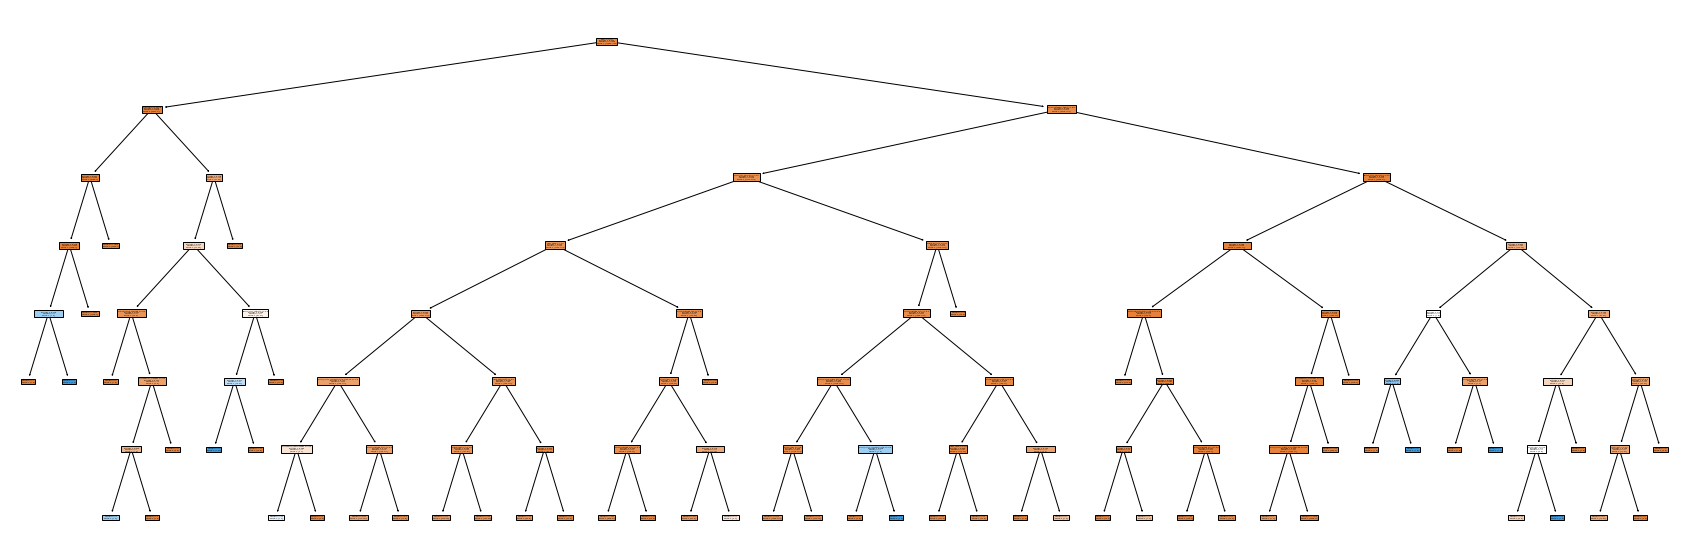

In [55]:
#Plot the tree
from sklearn import tree

fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(decision_tree, 
                   feature_names=X.columns,  
                   filled=True)
fig.savefig("decistion_tree.png")




Confusion matrix, without normalization
[[11595     7]
 [  684    49]]


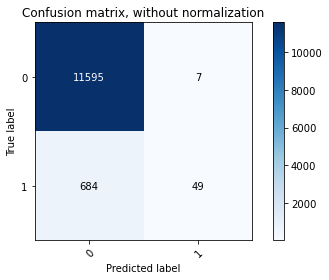

In [56]:
# evaluate confusion matrix for TRAIN SET

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['0', '1']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, y_train_predicted)
plt.show()

In [57]:
# evaluate precision, recall, F1-score on train set
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_predicted))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     11602
           1       0.88      0.07      0.12       733

    accuracy                           0.94     12335
   macro avg       0.91      0.53      0.55     12335
weighted avg       0.94      0.94      0.92     12335



Confusion matrix, without normalization
[[2893    1]
 [ 187    3]]


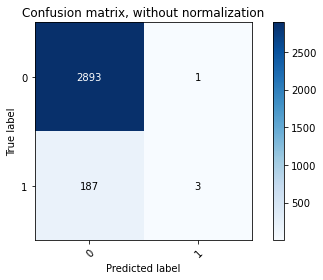

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2894
           1       0.75      0.02      0.03       190

    accuracy                           0.94      3084
   macro avg       0.84      0.51      0.50      3084
weighted avg       0.93      0.94      0.91      3084



In [58]:
# evaluate performance on test set
y_test_predicted = decision_tree.predict(X_test)
y_test_predicted_prob = decision_tree.predict_proba(X_test)[:,1]

plot_confusion_matrix(y_test, y_test_predicted)
plt.show()

print(classification_report(y_test, y_test_predicted))



In [59]:
y_pred_gini = decision_tree.predict(X_test)

print('Stats')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_gini))
print("balanced_accuracy:",metrics.balanced_accuracy_score(y_test, y_pred_gini))
print("brier_score_loss:",metrics.brier_score_loss(y_test, y_pred_gini))
print("f1_score:",metrics.f1_score(y_test,y_pred_gini))
print("recall_score:",metrics.recall_score(y_test, y_pred_gini))
print("precision_score:",metrics.precision_score(y_test, y_pred_gini))
print("roc_auc_score:",metrics.roc_auc_score(y_test, y_pred_gini))



precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_gini)

#this code plots the confusion matrix of our niave implementation of LOGISTIC REGRESSION


tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_gini).ravel()



print('True Negatives:', tn)
print('False Postives:', fp)
print('False Negatives:', fn)
print('True Positive:', tp)
print('Recall:', tp/(fn+tp))
print('Precision:', tp/(fp+tp))
print('Prevalence:', (fn+tp)/(tn+fp+fn+tp))

Stats
Accuracy: 0.9390402075226978
balanced_accuracy: 0.5077219655912414
brier_score_loss: 0.0609597924773022
f1_score: 0.03092783505154639
recall_score: 0.015789473684210527
precision_score: 0.75
roc_auc_score: 0.5077219655912414
True Negatives: 2893
False Postives: 1
False Negatives: 187
True Positive: 3
Recall: 0.015789473684210527
Precision: 0.75
Prevalence: 0.061608300907911806


# RANDOM FOREST

In [60]:
#building the model
from sklearn.ensemble import RandomForestClassifier
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                             param_grid={'n_estimators': [200, 300, 400, 500]}, 
                             cv=10)

rf_grid.fit(X_train, y_train)
print(rf_grid.best_estimator_)
print(rf_grid.best_score_)

RandomForestClassifier(n_estimators=400)
0.9405757524373619


In [61]:
random_forest = rf_grid.best_estimator_
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test).astype(int)
acc_train = round(random_forest.score(X_train, y_train) * 100, 2)
print("Random Forest accuracy score (train) is {}".format(acc_train))
print ("Random Forest accuracy score (test) is {}".format(round(accuracy_score(y_test,y_pred)*100,2)))


Random Forest accuracy score (train) is 100.0
Random Forest accuracy score (test) is 93.84


In [62]:
# get features importance for RANDOM FOREST

feat_importance = pd.DataFrame({'Variable': X.columns, 'Importance': random_forest.feature_importances_}).sort_values(by=['Importance'], ascending=False)
display(feat_importance)


,Variable,Importance
4,Age,0.100169
0,WeekOfMonth,0.053318
2,WeekOfMonthClaimed,0.052823
7,DriverRating,0.050577
5,Fault,0.029731
...,...,...
85,NumberOfCars_more than 8,0.000007
18,Make_Lexus,0.000006
24,Make_Porche,0.000004
17,Make_Jaguar,0.000004


In [63]:
#Random forest RMSE 

y_train_predicted = random_forest.predict(X_train)
RMSE_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted))
y_test_predicted = random_forest.predict(X_test)
RMSE_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted))

print('\n\nRoot Mean Squared Error on train set:', RMSE_train)
print('Root Mean Squared Error on test set:', RMSE_test)




Root Mean Squared Error on train set: 0.0
Root Mean Squared Error on test set: 0.2482101950120337


In [64]:
# predicted values 

pd.DataFrame({'True': y_train.values.flatten(), 'Predicted': y_train_predicted.flatten()})

,True,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12330,0,0
12331,0,0
12332,0,0
12333,0,0


In [65]:
# access all the fitted trees
random_forest.estimators_

[DecisionTreeClassifier(max_features='auto', random_state=372370418),
 DecisionTreeClassifier(max_features='auto', random_state=45712329),
 DecisionTreeClassifier(max_features='auto', random_state=85122961),
 DecisionTreeClassifier(max_features='auto', random_state=1116124746),
 DecisionTreeClassifier(max_features='auto', random_state=1479134715),
 DecisionTreeClassifier(max_features='auto', random_state=1013525810),
 DecisionTreeClassifier(max_features='auto', random_state=1099503953),
 DecisionTreeClassifier(max_features='auto', random_state=933687601),
 DecisionTreeClassifier(max_features='auto', random_state=1519911099),
 DecisionTreeClassifier(max_features='auto', random_state=383158726),
 DecisionTreeClassifier(max_features='auto', random_state=977433513),
 DecisionTreeClassifier(max_features='auto', random_state=562517580),
 DecisionTreeClassifier(max_features='auto', random_state=809513004),
 DecisionTreeClassifier(max_features='auto', random_state=1137299728),
 DecisionTreeCla

In [66]:
len(random_forest.estimators_)

400

Confusion matrix, without normalization
[[11602     0]
 [    0   733]]


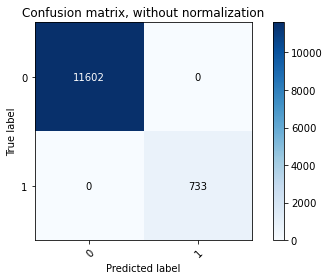

In [67]:
# evaluate confusion matrix on TRAIN SET

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['0', '1']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, y_train_predicted)
plt.show()

Bad performance on train set - overfitting, that is why we get 'perfect' results.

In [68]:
# evaluate precision, recall, F1-score on train set
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11602
           1       1.00      1.00      1.00       733

    accuracy                           1.00     12335
   macro avg       1.00      1.00      1.00     12335
weighted avg       1.00      1.00      1.00     12335



Confusion matrix, without normalization
[[2893    1]
 [ 189    1]]


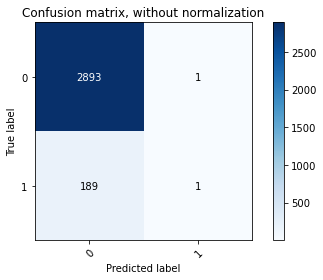

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2894
           1       0.50      0.01      0.01       190

    accuracy                           0.94      3084
   macro avg       0.72      0.50      0.49      3084
weighted avg       0.91      0.94      0.91      3084



In [69]:
# evaluate performance on test set
y_test_predicted = random_forest.predict(X_test)
y_test_predicted_prob = random_forest.predict_proba(X_test)[:,1]

plot_confusion_matrix(y_test, y_test_predicted)
plt.show()

print(classification_report(y_test, y_test_predicted))



In [70]:
y_pred_gini = random_forest.predict(X_test)

print('Stats')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_gini))
print("balanced_accuracy:",metrics.balanced_accuracy_score(y_test, y_pred_gini))
print("brier_score_loss:",metrics.brier_score_loss(y_test, y_pred_gini))
print("f1_score:",metrics.f1_score(y_test,y_pred_gini))
print("recall_score:",metrics.recall_score(y_test, y_pred_gini))
print("precision_score:",metrics.precision_score(y_test, y_pred_gini))
print("roc_auc_score:",metrics.roc_auc_score(y_test, y_pred_gini))



precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_gini)

#this code plots the confusion matrix of our niave implementation of LOGISTIC REGRESSION


tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_gini).ravel()



print('True Negatives:', tn)
print('False Postives:', fp)
print('False Negatives:', fn)
print('True Positive:', tp)
print('Recall:', tp/(fn+tp))
print('Precision:', tp/(fp+tp))
print('Prevalence:', (fn+tp)/(tn+fp+fn+tp))

Stats
Accuracy: 0.9383916990920882
balanced_accuracy: 0.5024588076965045
brier_score_loss: 0.061608300907911806
f1_score: 0.010416666666666666
recall_score: 0.005263157894736842
precision_score: 0.5
roc_auc_score: 0.5024588076965045
True Negatives: 2893
False Postives: 1
False Negatives: 189
True Positive: 1
Recall: 0.005263157894736842
Precision: 0.5
Prevalence: 0.061608300907911806


# FEATURE IMPORTANCE DECISION TREE VS RANDOM FOREST

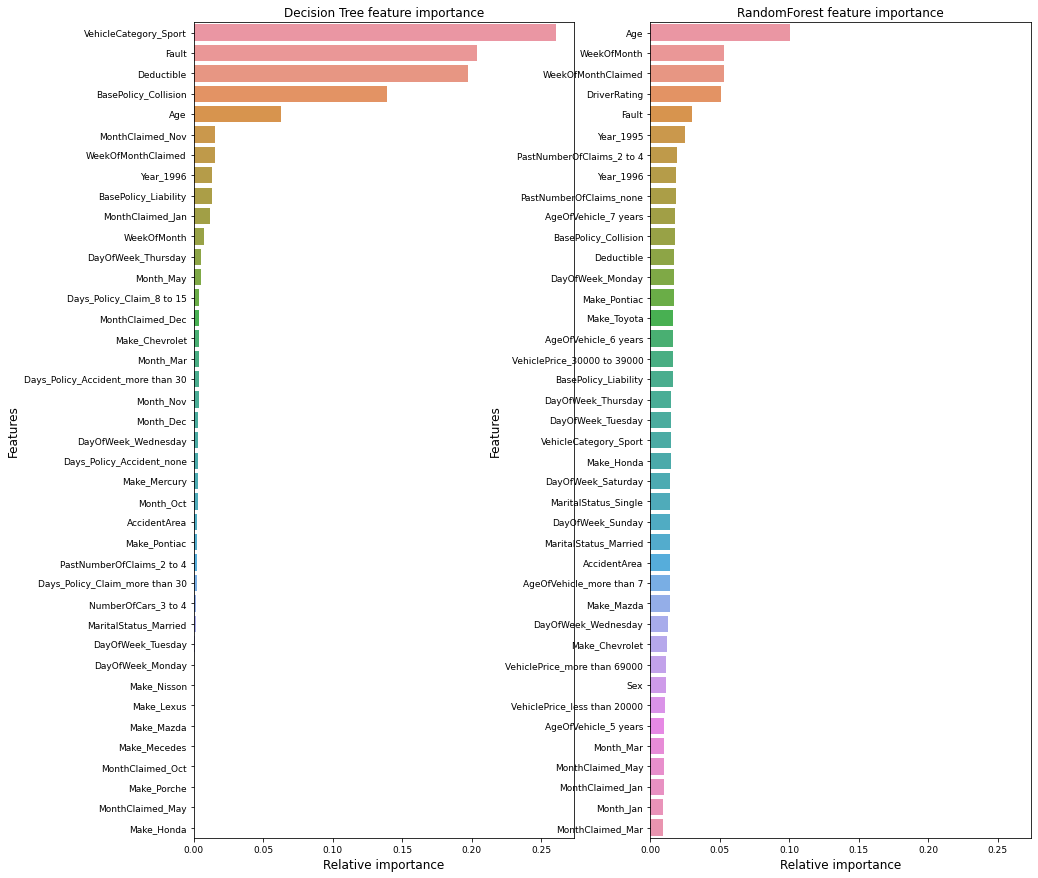

In [71]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("Decision Tree",decision_tree),("RandomForest",random_forest)]

nclassifier = 0
for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[col])
    x = g.set_xlabel("Relative importance",fontsize=12)
    y = g.set_ylabel("Features",fontsize=12)
    tick = g.tick_params(labelsize=9)
    t = g.set_title(name + " feature importance")
    nclassifier += 1

# LOGISTIC REGRESSION

In [72]:

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test).astype(int)


acc_train = round(logreg.score(X_train, y_train) * 100, 2)
print("LogisticRegression accuracy score (train) is {}".format(acc_train))
print ("LogisticRegression accuracy score (test) is {}".format(round(accuracy_score(y_test,y_pred)*100,2)))


LogisticRegression accuracy score (train) is 94.07
LogisticRegression accuracy score (test) is 93.84


In [73]:
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Coefficient"] = pd.Series(np.exp(logreg.coef_[0]))
coeff_df.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
5,Deductible,11.358343
69,VehicleCategory_Utility,1.752496
71,MonthClaimed_Dec,1.685360
48,VehiclePrice_less than 20000,1.471117
47,VehiclePrice_60000 to 69000,1.450275
...,...,...
79,MonthClaimed_Oct,0.456432
31,Days_Policy_Accident_none,0.442656
30,Days_Policy_Accident_more than 30,0.395013
28,Days_Policy_Accident_15 to 30,0.350022


Confusion matrix, without normalization
[[2894    0]
 [ 190    0]]


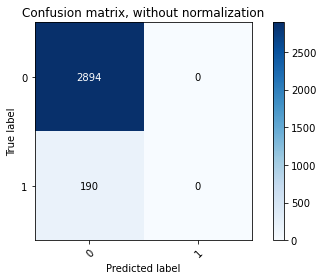

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2894
           1       0.00      0.00      0.00       190

    accuracy                           0.94      3084
   macro avg       0.47      0.50      0.48      3084
weighted avg       0.88      0.94      0.91      3084



In [74]:
# evaluate performance on test set
y_test_predicted = logreg.predict(X_test)
y_test_predicted_prob = logreg.predict_proba(X_test)[:,1]

plot_confusion_matrix(y_test, y_test_predicted)
plt.show()

print(classification_report(y_test, y_test_predicted))



In [75]:
y_pred_gini = logreg.predict(X_test)

print('Stats')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_gini))
print("balanced_accuracy:",metrics.balanced_accuracy_score(y_test, y_pred_gini))
print("brier_score_loss:",metrics.brier_score_loss(y_test, y_pred_gini))
print("f1_score:",metrics.f1_score(y_test,y_pred_gini))
print("recall_score:",metrics.recall_score(y_test, y_pred_gini))
print("precision_score:",metrics.precision_score(y_test, y_pred_gini))
print("roc_auc_score:",metrics.roc_auc_score(y_test, y_pred_gini))



precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_gini)

#this code plots the confusion matrix of our niave implementation of LOGISTIC REGRESSION


tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_gini).ravel()



print('True Negatives:', tn)
print('False Postives:', fp)
print('False Negatives:', fn)
print('True Positive:', tp)
print('Recall:', tp/(fn+tp))
print('Precision:', tp/(fp+tp))
print('Prevalence:', (fn+tp)/(tn+fp+fn+tp))

Stats
Accuracy: 0.9383916990920882
balanced_accuracy: 0.5
brier_score_loss: 0.061608300907911806
f1_score: 0.0
recall_score: 0.0
precision_score: 0.0
roc_auc_score: 0.5
True Negatives: 2894
False Postives: 0
False Negatives: 190
True Positive: 0
Recall: 0.0
Precision: nan
Prevalence: 0.061608300907911806


LogisticRegression AUC is 0.80456662


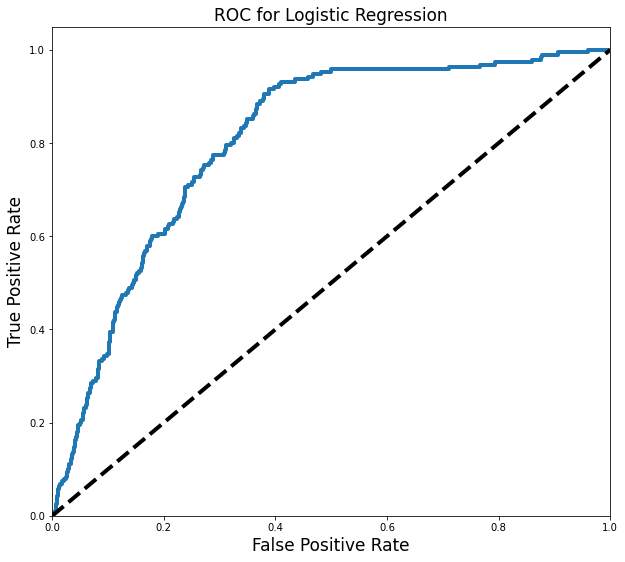

In [76]:
#The ROC curve
from sklearn.metrics import roc_curve, auc
y_score = logreg.decision_function(X_test) 
FPR, TPR, THR = roc_curve(y_test, y_score) 
ROC_AUC = auc(FPR, TPR)
print (logreg.__class__.__name__+" AUC is %2.8f" % ROC_AUC) 

p = plt.figure(figsize =[10,9])
p = plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
p = plt.plot([0,1],[0,1], 'k--', linewidth = 4)
p = plt.xlim([0.0,1.0])
p = plt.ylim([0.0,1.05])
p = plt.xlabel('False Positive Rate', fontsize = 17)
p = plt.ylabel('True Positive Rate', fontsize = 17)
p = plt.title('ROC for Logistic Regression', fontsize= 17)
plt.show()

# GRADIENT BOOST

Gradient Booster Classifier Success Rate : 93.90%


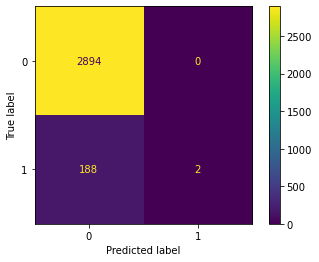

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc.fit(X_train,y_train)
p2=gbc.predict(X_test)
s2=accuracy_score(y_test,p2)
print("Gradient Booster Classifier Success Rate :", "{:.2f}%".format(100*s2))
metrics.plot_confusion_matrix(gbc, X_test, y_test)
plt.show()

In [78]:
y_pred_gini = gbc.predict(X_test)

print('Stats')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_gini))
print("balanced_accuracy:",metrics.balanced_accuracy_score(y_test, y_pred_gini))
print("brier_score_loss:",metrics.brier_score_loss(y_test, y_pred_gini))
print("f1_score:",metrics.f1_score(y_test,y_pred_gini))
print("recall_score:",metrics.recall_score(y_test, y_pred_gini))
print("precision_score:",metrics.precision_score(y_test, y_pred_gini))
print("roc_auc_score:",metrics.roc_auc_score(y_test, y_pred_gini))



precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_gini)

#this code plots the confusion matrix of our niave implementation of LOGISTIC REGRESSION


tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_gini).ravel()



print('True Negatives:', tn)
print('False Postives:', fp)
print('False Negatives:', fn)
print('True Positive:', tp)
print('Recall:', tp/(fn+tp))
print('Precision:', tp/(fp+tp))
print('Prevalence:', (fn+tp)/(tn+fp+fn+tp))

Stats
Accuracy: 0.9390402075226978
balanced_accuracy: 0.5052631578947369
brier_score_loss: 0.0609597924773022
f1_score: 0.020833333333333332
recall_score: 0.010526315789473684
precision_score: 1.0
roc_auc_score: 0.5052631578947369
True Negatives: 2894
False Postives: 0
False Negatives: 188
True Positive: 2
Recall: 0.010526315789473684
Precision: 1.0
Prevalence: 0.061608300907911806


# COMPARING MODELS

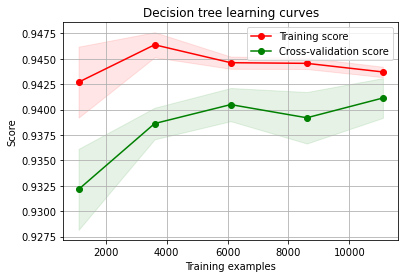

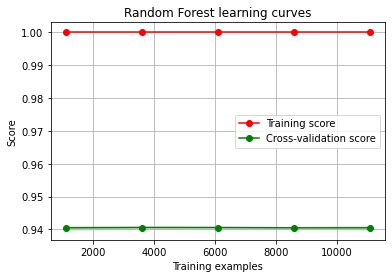

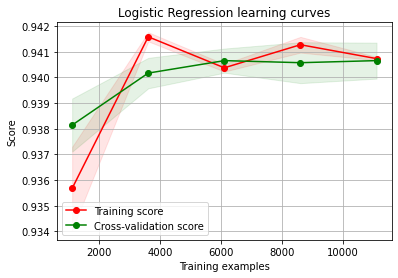

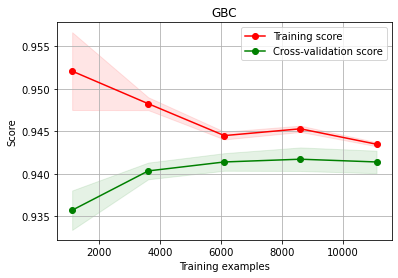

In [79]:
#Model evaluation

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


g = plot_learning_curve(decision_tree,"Decision tree learning curves",X_train,y_train,cv=10)
g = plot_learning_curve(random_forest,"Random Forest learning curves",X_train,y_train,cv=10)
g= plot_learning_curve(logreg, "Logistic Regression learning curves", X_train, y_train, cv=10)
g= plot_learning_curve(gbc, "GBC", X_train, y_train,cv=10)